# Imports

In [1]:
import gym
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import copy
from collections import defaultdict
from itertools import filterfalse, islice

from BlackJackUtility import get_total, game_result, plot_value_function, plot_policy_blackjack, average_wins, rand_average_wins

# Method

In [2]:
# Using OpenAI gym blackjack environemnt
environment = gym.make('Blackjack-v1')
new_step_api = True

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
# play (takes input)
episodes = 1
your_return = 0
for episode in range(episodes):
    state = environment.reset()
    done = False

    print("_______________________________________________")
    print(f"episode {episode}")
    print("You are the agent!")
    print(f"player has {environment.player}")
    print(f"dealer's up card: {state[1]}")
    print(f"the players current sum: {state[0]}, usable ace: {state[2]}")

    while not done:

        action = int(input("Press 1 to hit and 0 to stay: "))
        if action:
            print("hit")

        else:
            print("stay")

        print("action:", action)

        state, reward, done, info = environment.step(action)
        print(f"the players current sum: {state[0]}, usable ace: {state[2]}")

    result = game_result(environment, state) # how to fix spacing
    your_return += reward

print(f"your return is {your_return}")

_______________________________________________
episode 0
You are the agent!
player has [6, 1]
dealer's up card: 5
the players current sum: 17, usable ace: True
Press 1 to hit and 0 to stay: 1
hit
action: 1
the players current sum: 16, usable ace: False
Press 1 to hit and 0 to stay: 1
hit
action: 1
the players current sum: 19, usable ace: False
Press 1 to hit and 0 to stay: 0
stay
action: 0
the players current sum: 19, usable ace: False
state: (19, 5, False)
player has [6, 1, 9, 3]
the players current sum:19, dealer's one showing card:5, usable ace:False
dealer cards: [5, 3, 5, 5], dealer score: 18
your score: 19
agent wins :)
your return is 1.0


In [4]:
# this is a helper function we need for the mote_carlo_ES function
def ES_Greedy(action ,epsilon=0.3 ,n_actions=2):
    '''
    This function takes the best estimated action, eplsilon, and action space
    and returns some action.
    '''
    n = np.random.rand(1) # generate a random number from 0 to 1.

    if n >= 1-epsilon: # take random action in this case, otherwise take the suggested
      action = np.random.randint(n_actions)
    return action

In [5]:
def monte_carlo_ES(environment, N_episodes=100000, discount_factor=1, epsilon=0.1, theta=0.0001):
    '''
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    Args:
        environment: OpenAI gym environment.
        N_episodes: Number of episodes. Integer value.
        discount_factor: Gamma discount factor. Float betwen 0 and 1.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        theta: stoping threshold
    Returns:
        policy: a dictionary of estimated policy for blackjack
        V: a dictionary of estimated values for blackjack
        Q: a dictionary of estimated action function
        DELTA: list of deltas for each episode
    '''
    # initializations (defaultdict to avoid potential key error)
    policy = defaultdict(float)
    V = defaultdict(float) # estimated values for blackjack
    Q = defaultdict(float) # estimated action function for blackjack
    Counter_Visits= defaultdict(float) # number of visits to action function
    Counter_VisitsValue = defaultdict(float) # number of visits to the action function (increment mean)
    DELTA = [] # list of max difference between value functions per iteration

    for i in range(N_episodes):

        delta = 0 # item in DELTA (i.e. max difference between value functions)
        episode = [] # stores each state and reward for each episode

        # reset each episode
        state = environment.reset()
        reward = 0.0
        done = False
        action = np.random.randint(2) # action for the first state
        episode.append({'state':state , 'reward':reward, 'action':action}) # append first state, reward and action
        # Past states for signal visit Monte Carlo
        state_action = [(state,action)]
        # enumerate for each episode
        while not done:

            # take action and find next state, reward and check if the episode is done (True)
            (state, reward, done, prob) = environment.step(action)

            # check if a policy for the state exists
            if isinstance(policy[state], np.int64):
                # obtain action from policy
                action = ES_Greedy(round(policy[state]), epsilon, 2) # call ES_Greedy function
            else:
                # if no policy for the state exists select a random action
                action = np.random.randint(2)

            # add state reward and action to list
            episode.append({'state':state, 'reward':reward, 'action':action})
            # add states action this is for first visit only
            state_action.append((state,action))

        episode.reverse() # reverse list as the return is calculated from the last state
        state_action.reverse() # append the state-action pairs to a list

        # initialize the expected total discount reward
        G = 0

        for t,step in enumerate(episode):

            # check flag for first visit
            G = discount_factor*G + step['reward']

            # check flag for first visit
            Counter_Visits[step['state'], step['action']] += 1 # increment counter for action
            Counter_VisitsValue[step['state']] += 1  # increment counter for value function

            # if the action function value does not exist, create an array to store them
            if not isinstance(Q[step['state']],np.ndarray):
                Q[step['state']]= np.zeros(2)

            # calculate mean of action function Q Value functions V using the recursive definition of mean
            Q_s_t = Q[step['state']][step['action']]
            Q[step['state']][step['action']] += (Counter_Visits[step['state'], step['action']]**-1)*(G-Q_s_t)

            # record the old value of the value function
            v = V[step['state']]
            V[step['state']] += (Counter_VisitsValue[step['state']]**-1)*(G-v)

            # update the policy to select the action fuciton argment with the largest value
            policy[step['state']] = np.random.choice(np.where(Q[step['state']] == Q[step['state']].max())[0])

            # find max difference between all value functions per iteration
            delta = max(delta,abs(v-V[step['state']]))

        DELTA.append(delta)

        if delta < theta:
            break

    return policy, V, Q, DELTA

In [6]:
# test
policy, V, Q, DELTA = monte_carlo_ES( environment, N_episodes=50000, discount_factor= 0.9, epsilon = 0.3, theta=-1) # force this to run all episodes

In [7]:
# See outputs
print("====================== DELTA ======================")
print(DELTA[10000: 10005])
print("\n======================== V ========================")
for state, value in islice(V.items(), 5):
    print(f"State: {state}, Value: {value}")
print("\n======================== Q ========================")
for state, value in islice(Q.items(), 5):
    print(f"State: {state}, Value: {value}")
print("\n===================== Policy ======================")
for state, value in islice(policy.items(), 5):
    print(f"State: {state}, Value: {value}")

====================== DELTA ======================
[0.003120121835141876, 0.000938966180296319, 0.004954209387104114, 0.04085714285714287, 0.0012745995423341094]

======================== V ========================
State: (29, 8, False), Value: -1.0
State: (19, 8, False), Value: 0.36727739726027425
State: (14, 8, False), Value: -0.41620855614973246
State: (12, 6, False), Value: -0.20143810240963841
State: (16, 6, True), Value: 0.12650495049504956

======================== Q ========================
State: (29, 8, False), Value: [-1. -1.]
State: (19, 8, False), Value: [ 0.62529002 -0.35954248]
State: (14, 8, False), Value: [-0.43587444 -0.40323373]
State: (12, 6, False), Value: [-0.20551471 -0.19860944]
State: (16, 6, True), Value: [0.10384615 0.15055102]

===================== Policy ======================
State: (19, 8, False), Value: 0
State: (29, 8, False), Value: 0
State: (14, 8, False), Value: 1
State: (16, 6, True), Value: 1
State: (12, 6, False), Value: 1


In [8]:
average, std_win = average_wins(environment, policy, episodes=50000)
print("average wins:", average, std_win)

average wins: 0.42886 0.0022133192286699177


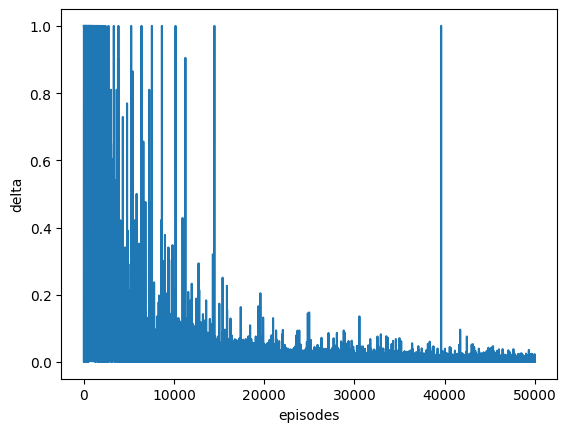

In [9]:
plt.plot(DELTA)
plt.xlabel("episodes")
plt.ylabel("delta")
plt.show()

In [10]:
# tuning hyperparameters
## episode length
accuracy1 = []
episodes = []

for n_episode in [1,50,100,500,1000,5000,10000,50000,100000]:
    print("n_episode: ", str(n_episode))
    policy, V, Q, DELTA = monte_carlo_ES(environment, N_episodes=n_episode, discount_factor=1, theta = 0)
    average, std_win = average_wins(environment, policy, episodes=100000)
    print("n_episode: ", str(n_episode), " average: ", str(average))
    accuracy1.append(average)
    episodes.append(n_episode)

n_episode:  1
n_episode:  1  average:  0.27982
n_episode:  50
n_episode:  50  average:  0.33882
n_episode:  100
n_episode:  100  average:  0.33946
n_episode:  500
n_episode:  500  average:  0.35825
n_episode:  1000
n_episode:  1000  average:  0.39003
n_episode:  5000
n_episode:  5000  average:  0.41792
n_episode:  10000
n_episode:  10000  average:  0.42055
n_episode:  50000
n_episode:  50000  average:  0.43156
n_episode:  100000
n_episode:  100000  average:  0.43287


In [11]:
## discount factor
accuracy2=[]
discounts=[]

for discount in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    policy, V, Q, delta = monte_carlo_ES(environment, N_episodes=100000, discount_factor=discount, epsilon=0.5, theta=-1)
    average, std_win=average_wins(environment, policy, episodes=100000)
    print("discount: ", str(discount), " average: ", str(average))
    discounts.append(discount)
    accuracy2.append(average)

discount:  0  average:  0.27198
discount:  0.1  average:  0.39923
discount:  0.2  average:  0.41467
discount:  0.3  average:  0.42612
discount:  0.4  average:  0.42814
discount:  0.5  average:  0.42827
discount:  0.6  average:  0.43164
discount:  0.7  average:  0.43021
discount:  0.8  average:  0.43012
discount:  0.9  average:  0.43023
discount:  1.0  average:  0.42852


In [12]:
## epsilon
accuracy3=[]
epsilons=[]

for es in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    policy, V, Q, delta = monte_carlo_ES(environment, N_episodes=100000, discount_factor=1, epsilon=es, theta=-1)
    average, std_win = average_wins(environment, policy, episodes=100000)
    print("epsilon: ", str(es), " average: ", str(average))
    epsilons.append(es)
    accuracy3.append(average)

epsilon:  0  average:  0.43575
epsilon:  0.1  average:  0.43172
epsilon:  0.2  average:  0.43182
epsilon:  0.3  average:  0.43276
epsilon:  0.4  average:  0.43216
epsilon:  0.5  average:  0.42898
epsilon:  0.6  average:  0.43048
epsilon:  0.7  average:  0.42678
epsilon:  0.8  average:  0.42069
epsilon:  0.9  average:  0.42192


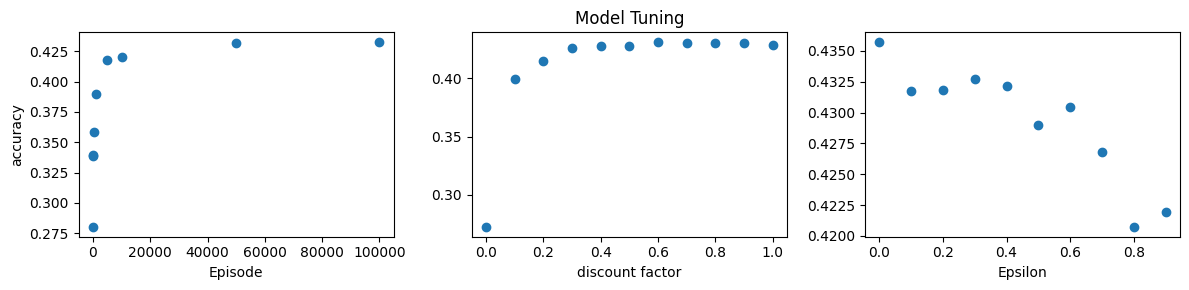

In [13]:
# visualize tuning
fig, ax = plt.subplots(1, 3, figsize = (12, 3))
ax[0].scatter(episodes, accuracy1)
ax[1].scatter(discounts, accuracy2)
ax[2].scatter(epsilons, accuracy3)

ax[0].set(xlabel = "Episode",
          ylabel = "accuracy")
ax[1].set(title = "Model Tuning",
          xlabel = "discount factor")
ax[2].set(xlabel = "Epsilon")

plt.tight_layout()

In [14]:
# tuned model result
policy, V, Q, DELTA = monte_carlo_ES(environment, N_episodes=100000, discount_factor=1.0, epsilon = 0.1, theta=-1)
average ,std_win = average_wins(environment,policy,episodes=100000)

In [15]:
print("average wins:",average, std_win)

average wins: 0.42841 0.001564847826147961


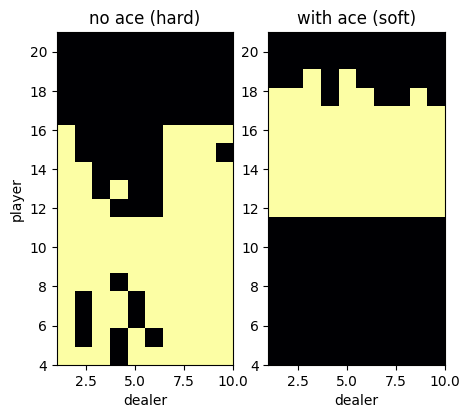

In [16]:
## Visualizations
# Policy
plot_policy_blackjack(policy)

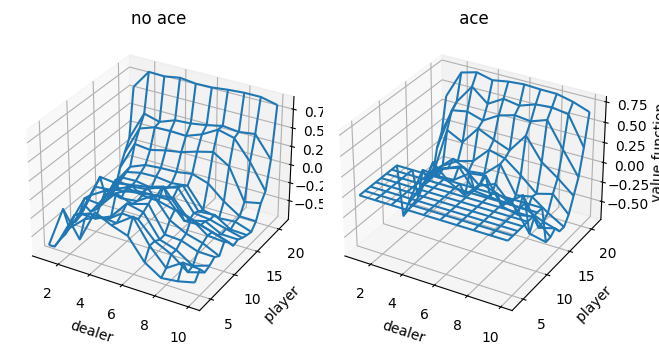

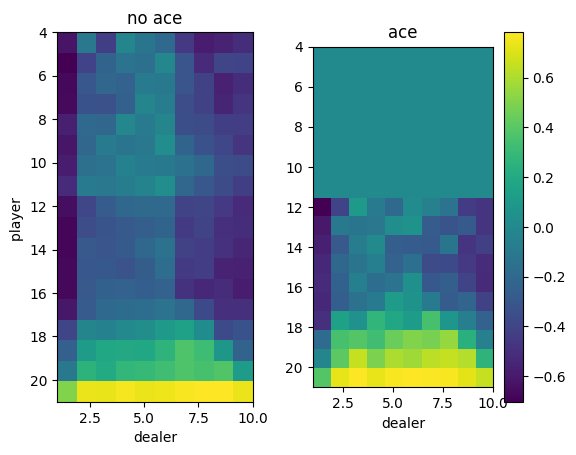

In [17]:
# Q-function value
plot_value_function(V)

In [18]:
# Compare to random action
average, std_win = rand_average_wins(environment, None, episodes=10000)
print("average wins:", average, std_win)

average wins: 0.2814 0.004496821544157605
